In [1]:
import numpy as np
import torch
from torchvision import transforms
from tifffile import imread
import sys
sys.path.append('../')
from noise_model.PixelCNN import PixelCNN
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load trained noise model

In [3]:
noise_model_location = '../nm_checkpoint/conv/final_params.ckpt'
noise_model = PixelCNN.load_from_checkpoint(noise_model_location).eval().to(device)

Set sample shape and sample from noise model.
Move sample to cpu and convert to numpy array

In [4]:
img_shape = [1, 1, 128, 128]
sample = noise_model.sample(img_shape).detach().cpu().numpy()

Load real noise samples

In [5]:
noise_location = '../data/conv/noise.tif'
noise = imread(noise_location)

Visually compare real noise against noise model sample

Text(0.5, 1.0, 'Noise model sample')

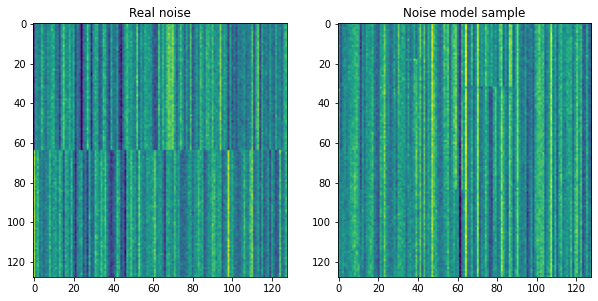

In [6]:
vmin = np.percentile(noise, 0.1)
vmax = np.percentile(noise, 99.9)

fig, ax = plt.subplots(1, 2, figsize=[10,10])
ax[0].imshow(noise[0], vmin=vmin, vmax=vmax)
ax[0].set_title('Real noise')

ax[1].imshow(sample[0, 0], vmin=vmin, vmax=vmax)
ax[1].set_title('Noise model sample')

Create 2D autocorrelation function and calculate for real noise and noise model sample

In [7]:
def ac(a):
    a = a-a.mean()
    results = np.zeros((25, 25))
    for i in range(0, 25):
        for j in range(0, 25):
            if i == 0 and j == 0:
                covar = np.mean(a**2)
            if i == 0 and j != 0:
                covar = np.mean(a[...,j:]*a[...,:-j])
            if j == 0 and i != 0:
                covar = np.mean(a[...,i:,:]*a[...,:-i,:])
            if i != 0 and j != 0:
                covar = np.mean(a[...,i:,j:]*a[...,:-i,:-j])
            results[i, j] = covar

    return results/(a**2).mean()

In [8]:
ac_real_noise = ac(noise[0])
ac_sample = ac(sample)

Text(0.5, 1.0, 'Noise model sample')

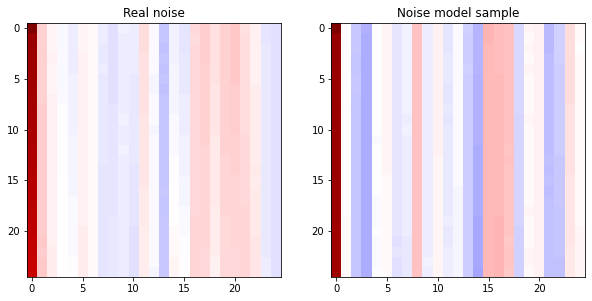

In [9]:
v = 1

fig, ax = plt.subplots(1, 2, figsize=[10, 10])
ax[0].imshow(ac_real_noise, cmap='seismic', vmin=-v, vmax=v)
ax[0].set_title('Real noise')
    
ax[1].imshow(ac_sample, cmap='seismic', vmin=-v, vmax=v)
ax[1].set_title('Noise model sample')